In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

def generate_plots_from_csv(csv_file_path):
    """
    Generate bar charts, a pie chart, and a summary table from the input CSV file.

    Parameters
    ----------
    csv_file_path : str
        The path to the input CSV file.
    """
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)

    # Drop the 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    # Extract the year from the column names and create a new DataFrame for summing
    years = list(range(2000, 2025))  # Adjust the range as needed
    products = ['GFC_loss_year_', 'TMF_deg_', 'RADD_year_', 'MODIS_fire_']

    # Create a new DataFrame to store the sums
    sum_df = pd.DataFrame(index=years, columns=products).fillna(0)

    # Sum the rows for each year and product where values are greater than zero
    for product in products:
        for year in years:
            column_name = f'{product}{year}'
            if column_name in df.columns:
                sum_df.loc[year, product] = (df[column_name] > 0).sum()

    # Count the occurrences of each EUDR risk category
    eudr_risk_counts = df['EUDR_risk'].value_counts()

    # Data for pie chart
    labels = eudr_risk_counts.index.tolist()  # Labels
    sizes = eudr_risk_counts.values.tolist()  # Corresponding sizes

    # Define the colors for each label
    color_map = {
        'more_info_needed': '#EB9148',  # Orange
        'high': '#E45756',  # Red
        'low': '#6CC086'  # Green
    }
    colors = [color_map[label] for label in labels]
    
    background_color = '#1E2A35'
    explode = [0.1] * len(sizes)  # Explode all slices for emphasis

    # Create a function to display absolute numbers instead of percentages
    def func(pct, allvals):
        absolute = int(pct / 100. * sum(allvals))
        return f'{absolute}'  # Show absolute values

    # Plotting the bar charts using the summed data
    sns.set_theme(style="darkgrid", rc={"axes.facecolor": "#2e3b45", "grid.color": "#485A64"})
    plt.rcParams['axes.edgecolor'] = '#ffffff'
    plt.rcParams['axes.labelcolor'] = '#ffffff'
    plt.rcParams['xtick.color'] = '#ffffff'
    plt.rcParams['ytick.color'] = '#ffffff'

    # Function to assign color based on year
    def color_by_year(year):
        if year >= 2020:
            return '#ff6347'  # Red
        else:
            return '#00b687'  # Green

    # Create the figure with subplots
    fig = plt.figure(figsize=(30, 15))
    gs = fig.add_gridspec(4, 4, width_ratios=[1, 3, 1, 1])
    fig.patch.set_facecolor(background_color)  # Set background color

    # GFC disturbance chart
    ax1 = fig.add_subplot(gs[0, 1:3])
    sns.barplot(x=sum_df.index, y=sum_df['GFC_loss_year_'], ax=ax1, palette=[color_by_year(y) for y in sum_df.index])
    ax1.set_title('# of plots with disturbances detected by GFC', color='white')
    ax1.set_ylabel('# of plots', color='white')

    # TMF deforestation chart
    ax2 = fig.add_subplot(gs[1, 1:3])
    sns.barplot(x=sum_df.index, y=sum_df['TMF_deg_'], ax=ax2, palette=[color_by_year(y) for y in sum_df.index])
    ax2.set_title('# of plots with disturbances detected by TMF Degradation', color='white')
    ax2.set_ylabel('# of plots', color='white')

    # RADD disturbance chart
    ax3 = fig.add_subplot(gs[2, 1:3])
    sns.barplot(x=sum_df.index, y=sum_df['RADD_year_'], ax=ax3, palette=[color_by_year(y) for y in sum_df.index])
    ax3.set_title('# of plots with disturbances detected by RADD', color='white')
    ax3.set_ylabel('# of plots', color='white')

    # MODIS fire detection chart
    ax4 = fig.add_subplot(gs[3, 1:3])
    sns.barplot(x=sum_df.index, y=sum_df['MODIS_fire_'], ax=ax4, palette=[color_by_year(y) for y in sum_df.index])
    ax4.set_title('# of plots with fires detected by MODIS', color='white')
    ax4.set_ylabel('# of plots', color='white')

    # Set common properties for bar plots
    for ax in [ax1, ax2, ax3, ax4]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_color('#ffffff')
        ax.spines['left'].set_color('#ffffff')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Create the pie chart
    ax_pie = fig.add_subplot(gs[2:, 0], facecolor=background_color)  # Adjusted to take up more space
    ax_pie.set_facecolor(background_color)
    wedges, texts, autotexts = ax_pie.pie(sizes, explode=explode, labels=labels, colors=colors,
                                          autopct=lambda pct: func(pct, sizes), shadow=True, 
                                          startangle=0, labeldistance=1.1)

    # Position the labels outside the segments
    for text in texts:
        text.set_color('white')  # Set label color to white

    # Set the title for the pie chart
    ax_pie.set_title('Plots by EUDR Risk Category', color='white')

    # Ensure a perfect circle for the pie chart
    ax_pie.axis('equal')

    # Hide the empty subplots in the first and third columns
    for i in range(4):
        fig.add_subplot(gs[i, 0]).axis('off')

    # Create the table
    ax_table = fig.add_subplot(gs[0:2, 3], facecolor=background_color)
    ax_table.axis('off')  # Hide the axis

    # Add the summary table in the top right corner
    summary_df = df.groupby('Country').agg(
        total_plot_area_ha=('Plot_area_ha', 'sum')
    ).reset_index()

    # Format the 'total_plot_area_ha' to 2 decimal places
    summary_df['total_plot_area_ha'] = summary_df['total_plot_area_ha'].round(2)

    # Create a pivot table to count the plots for each EUDR_risk category
    pivot_df = df.pivot_table(index='Country', columns='EUDR_risk', values='Plot_area_ha', aggfunc='count', fill_value=0).reset_index()

    # Merge the summary_df and pivot_df
    summary_df = summary_df.merge(pivot_df, on='Country', how='left')

    # Rename the columns for clarity
    summary_df.columns = ['Country', 'Total Plot Area (ha)', 'High Risk', 'Low Risk', 'More Info Needed']

    # Wrap the column titles
    wrapped_columns = [textwrap.fill(col, width=10) for col in summary_df.columns]

    # Create the table
    table = ax_table.table(cellText=summary_df.values, colLabels=wrapped_columns, cellLoc='center', loc='center')

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(0.6, 1.2)  # Adjust the scaling to make the table thinner

    # Set the background color
    background_color = '#1E2A35'
    fig.patch.set_facecolor(background_color)
    ax_table.set_facecolor(background_color)

    # Define colors for each risk category
    color_map = {
        'High Risk': '#E45756',  # Red
        'Low Risk': '#6CC086',  # Green
        'More Info Needed': '#EB9148'  # Orange
    }

    # Set the cell colors
    for key, cell in table.get_celld().items():
        cell.set_edgecolor('white')
        cell.set_text_props(color='white')
        cell.set_facecolor(background_color)
        if key[0] > 0:  # Skip the header row
            value = summary_df.iloc[key[0] - 1, key[1]]
            if value == 0:
                cell.get_text().set_text('')  # Remove the text for zero values
            else:
                if key[1] == 2:  # High Risk column
                    cell.set_facecolor(color_map['High Risk'])
                elif key[1] == 3:  # Low Risk column
                    cell.set_facecolor(color_map['Low Risk'])
                elif key[1] == 4:  # More Info Needed column
                    cell.set_facecolor(color_map['More Info Needed'])

    # Adjust column widths and row heights dynamically based on the length of the wrapped text
    for i, col in enumerate(wrapped_columns):
        max_len = max(len(line) for line in col.split('\n'))
        for key, cell in table.get_celld().items():
            if key[1] == i:
                cell.set_width(max_len * 0.1)  # Adjust the width as needed
            if key[0] == 0:  # Adjust the height of the header cells
                cell.set_height(len(col.split('\n')) * 0.1)  # Adjust the height as needed

    plt.tight_layout()

    # Save or display the plot
    plt.savefig("combined_plot.png", facecolor=fig.get_facecolor(), transparent=True)
    plt.show()

# # Example usage
# csv_file_path = r'C:/Users/Arnell/Documents/GitHub/whisp_sustaain/notebooks/whisp_output_table_w_risk.csv'
# generate_plots_from_csv(csv_file_path)

C:\Users\Arnell\AppData\Local\Temp\ipykernel_35544\4292123832.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sum_df = pd.DataFrame(index=years, columns=products).fillna(0)
C:\Users\Arnell\AppData\Local\Temp\ipykernel_35544\4292123832.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sum_df.index, y=sum_df['GFC_loss_year_'], ax=ax1, palette=[color_by_year(y) for y in sum_df.index])
C:\Users\Arnell\AppData\Local\Temp\ipykernel_35544\4292123832.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for 

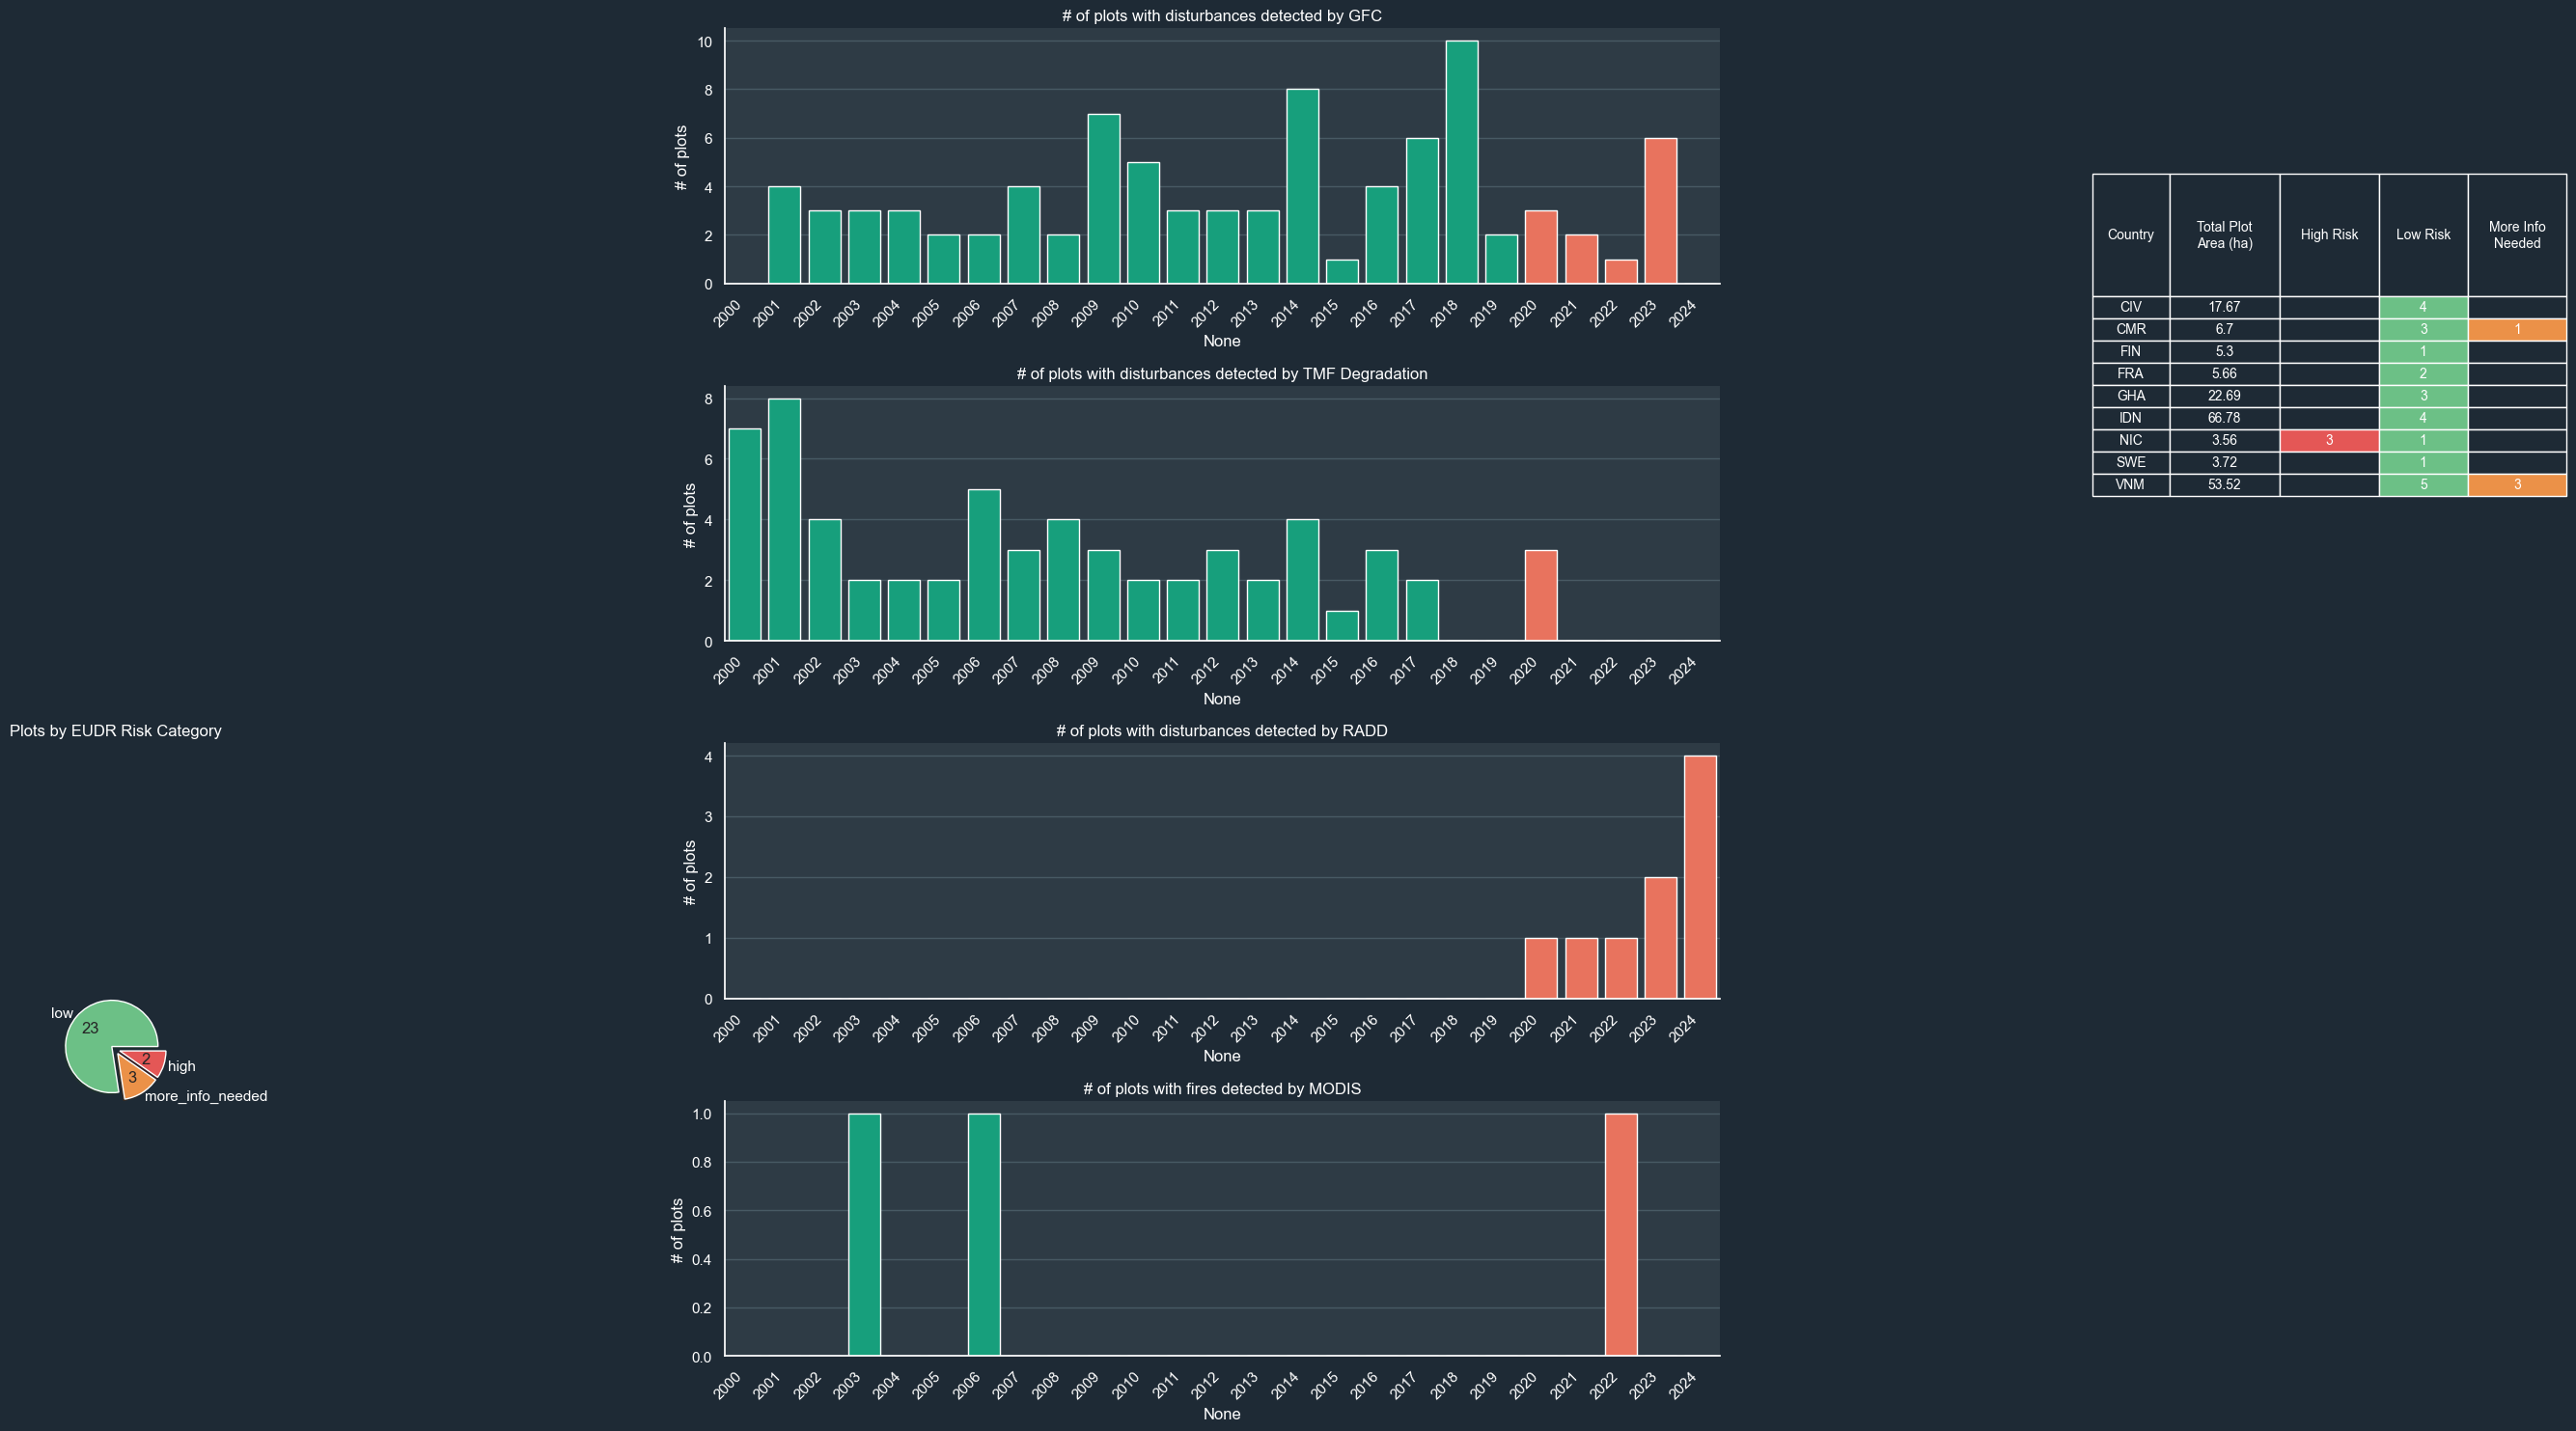

In [74]:
# Example usage
csv_file_path = r'C:/Users/Arnell/Documents/GitHub/whisp_sustaain/notebooks/whisp_output_table_w_risk.csv'

generate_plots_from_csv(csv_file_path)

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import textwrap

# # Load the CSV file into a DataFrame
# df = pd.read_csv('whisp_output_table_w_risk.csv')

# # Drop the 'Unnamed: 0' column if it exists
# if 'Unnamed: 0' in df.columns:
#     df = df.drop(columns=['Unnamed: 0'])

# # Group by the 'Country' column and calculate the sum of 'Plot_area_ha'
# summary_df = df.groupby('Country').agg(
#     total_plot_area_ha=('Plot_area_ha', 'sum')
# ).reset_index()

# # Format the 'total_plot_area_ha' to 2 decimal places
# summary_df['total_plot_area_ha'] = summary_df['total_plot_area_ha'].round(2)

# # Create a pivot table to count the plots for each EUDR_risk category
# pivot_df = df.pivot_table(index='Country', columns='EUDR_risk', values='Plot_area_ha', aggfunc='count', fill_value=0).reset_index()

# # Merge the summary_df and pivot_df
# summary_df = summary_df.merge(pivot_df, on='Country', how='left')

# # Rename the columns for clarity
# summary_df.columns = ['Country', 'Total Plot Area (ha)', 'High Risk', 'Low Risk', 'More Info Needed']

# # Wrap the column titles
# wrapped_columns = [textwrap.fill(col, width=10) for col in summary_df.columns]

# # Plot the table
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis('off')  # Hide the axis

# # Create the table
# table = ax.table(cellText=summary_df.values, colLabels=wrapped_columns, cellLoc='center', loc='center')

# # Style the table
# table.auto_set_font_size(False)
# table.set_fontsize(10)
# table.scale(0.6, 1.2)  # Adjust the scaling to make the table thinner

# # Set the background color
# background_color = '#1E2A35'
# fig.patch.set_facecolor(background_color)
# ax.set_facecolor(background_color)

# # Define colors for each risk category
# color_map = {
#     'High Risk': '#E45756',  # Red
#     'Low Risk': '#6CC086',  # Green
#     'More Info Needed': '#EB9148'  # Orange
# }

# # Set the cell colors
# for key, cell in table.get_celld().items():
#     cell.set_edgecolor('white')
#     cell.set_text_props(color='white')
#     cell.set_facecolor(background_color)
#     if key[0] > 0:  # Skip the header row
#         value = summary_df.iloc[key[0] - 1, key[1]]
#         if value == 0:
#             cell.get_text().set_text('')  # Remove the text for zero values
#         else:
#             if key[1] == 2:  # High Risk column
#                 cell.set_facecolor(color_map['High Risk'])
#             elif key[1] == 3:  # Low Risk column
#                 cell.set_facecolor(color_map['Low Risk'])
#             elif key[1] == 4:  # More Info Needed column
#                 cell.set_facecolor(color_map['More Info Needed'])

# # Adjust column widths and row heights dynamically based on the length of the wrapped text
# for i, col in enumerate(wrapped_columns):
#     max_len = max(len(line) for line in col.split('\n'))
#     for key, cell in table.get_celld().items():
#         if key[1] == i:
#             cell.set_width(max_len * 0.01)  # Adjust the width as needed
#         if key[0] == 0:  # Adjust the height of the header cells
#             cell.set_height(len(col.split('\n')) * 0.1)  # Adjust the height as needed

# plt.tight_layout()

# # Save or display the plot
# plt.savefig("summary_table.png", facecolor=fig.get_facecolor(), transparent=True)
# plt.show()